In [1]:
import pandas as pd

import tensorflow as tf
import numpy as np
from keras import layers
from keras.models import load_model, Model,Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from datetime import datetime
from livelossplot.inputs.tf_keras import PlotLossesCallback
from skimage import morphology


import seaborn as sns #https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b  because of the dataset size
import statsmodels.api as sm

from tensorflow.python.client import device_lib

import cv2
from PIL import Image
import pickle
from sklearn.metrics import multilabel_confusion_matrix

import sys
sys.path.append("..")
import sklearn as sk
import keras_tuner as kt


2024-07-09 05:58:44.410259: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 05:58:44.887031: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 05:58:46.230548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# print(device_lib.list_local_devices())
# print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices()))
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         print(e)


In [3]:
tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [4]:
x_train.shape, y_train.shape


((60000, 28, 28), (60000,))

In [5]:
train_df = pd.DataFrame({'image': [img for img in x_train]})
train_df["label"] = y_train

test_df = pd.DataFrame({'image': [img for img in x_test]})
test_df["label"] = y_test

train_df

image  label
0      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      5
1      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0
2      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      4
3      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      1
4      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      9
...                                                  ...    ...
59995  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      8
59996  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      3
59997  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      5
59998  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      6
59999  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      8

[60000 rows x 2 columns]

In [6]:
test_df.head()

image  label
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      7
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      1
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      4

# Checking classes

In [7]:
np.sort(train_df.label.unique().tolist())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
np.sort(test_df.label.unique().tolist())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We have all classes in both datasets.
What about the frequence ? 


<Axes: >

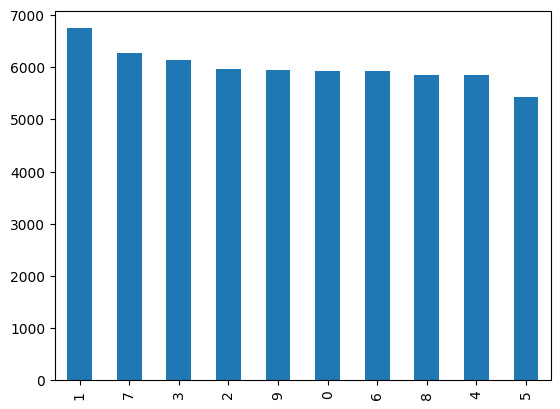

In [9]:
train_df.label.value_counts().plot(kind="bar")

<Axes: >

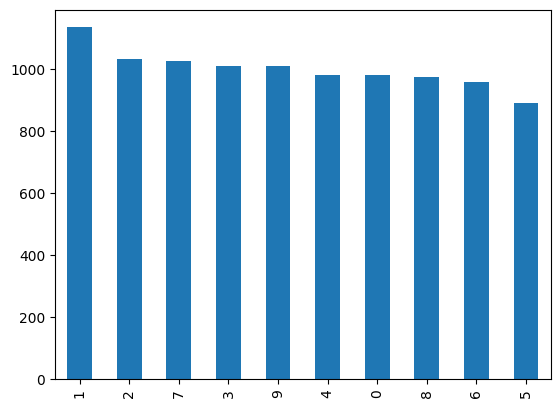

In [10]:
test_df.label.value_counts().plot(kind="bar")

# Defining the baseline (human level performance) and checking where we are right now with a rough model

HLP Accuracy : 99.87%
Loss : categorical cross entropy 

https://arxiv.org/pdf/2001.09136v6.pdf model architecture that achieved the best accuracy. Let's check where we are without data processing.


Shaping the inputs

In [11]:
stage = "rough"

In [12]:
train_df.image.values[0].shape

(28, 28)

(28, 28, 3)


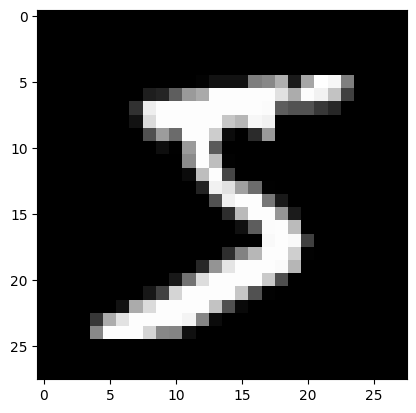

In [13]:
img = Image.fromarray((train_df.image.values[0]).astype(np.uint8)).convert('RGB')
plt.figure()
img = np.asarray(img)
plt.imshow(img)
print(img.shape)

In [14]:
train_df["images_rgb"] = train_df.image.apply(lambda img : np.asarray(Image.fromarray((img).astype(np.uint8)).convert('RGB')) )
train_df.images_rgb.values[0].shape

(28, 28, 3)

In [15]:
test_df["images_rgb"] = test_df.image.apply(lambda img : np.asarray(Image.fromarray((img).astype(np.uint8)).convert('RGB')) )

test_df.images_rgb.values[0].shape

(28, 28, 3)

In [16]:
W = train_df.images_rgb.values[0].shape[0]
H = train_df.images_rgb.values[0].shape[1]

train_input = np.array([img for img in train_df.images_rgb.values]).reshape(len(train_df), W, H, 3)
test_input = np.array([img for img in test_df.images_rgb.values]).reshape(len(test_df), W, H, 3)

train_input[0].shape, test_input[0].shape

((28, 28, 3), (28, 28, 3))

In [17]:
train_input.shape, y_train.shape, test_input.shape, y_test.shape

((60000, 28, 28, 3), (60000,), (10000, 28, 28, 3), (10000,))

In [18]:
from tensorflow.keras import backend as K
import keras

@keras.saving.register_keras_serializable(package="my_custom_metrics", name="recall_m")
def recall_m(y_true, y_pred):

    y_pred = tf.argmax(y_pred, axis=-1)

    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0.0, 1.0)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0.0, 1.0)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
@keras.saving.register_keras_serializable(package="my_custom_metrics", name="precision_m")
def precision_m(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0.0, 1.0)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0.0, 1.0)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
@keras.saving.register_keras_serializable(package="my_custom_metrics", name="f1_m")
def f1_m(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
def create_model(hp, default_model = False):
    if default_model :
        model = Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(W, H, 3)))#128
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(W, H, 3)))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(160, (3, 3), activation='relu', input_shape=(W, H, 3)))
        model.add(layers.BatchNormalization())
        #model.add(layers.Dropout(0.5))
        learning_rate = 0.00001
    else:

        n_conv_layers = hp.Int("n_conv_layers", 2, 4, step = 1)
        use_batch_norm = hp.Choice("use_batch_norm", [True, False])
        use_dropout = hp.Choice("use_dropout", [True, False])
        learning_rate = hp.Float('learning_rate', 0.000001, 0.001)

        model = Sequential()

        for n in range(n_conv_layers):
            #Get Conv layers units and filters
            conv_unit = hp.Int(f"conv_{n}_unit", 32, 256, step = 32)
            conv_filter = hp.Int(f"conv_{n}_filter", 2, 5, step = 1)
            model.add(layers.Conv2D(conv_unit, (conv_filter, conv_filter), activation='relu', input_shape=(W, H, 3)))

            #Apply batch norm
            if use_batch_norm : model.add(layers.BatchNormalization())

            #Apply dropout
            if use_dropout : 
                dropout_rate = hp.Float(f'dropout_rate_{n}', 0.1, 0.5)
                model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['sparse_categorical_accuracy', precision_m, recall_m, f1_m])
    return model
    

In [20]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{stage}/")

# model = create_model(None, default_model = True)

# model.fit(train_input, 
#           y_train , 
#           #validation_split= 0.05, 
#           validation_data=(test_input, y_test),
#           epochs= 150, 
#           batch_size = 1024,
#           callbacks=[tensorboard_callback]
#           )
# model.save('./checkpoints/model_v1.keras')
model = tf.keras.models.load_model('./checkpoints/model_v1.keras')

test_target_prob = model.predict(test_input)

m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(y_test, test_target_prob)
sk.metrics.f1_score(y_test.reshape(-1,1), test_target_prob.argmax(axis = -1).reshape(-1,1), average = "weighted"), m.result()


2024-07-09 05:58:50.257070: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 05:58:50.303271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 05:58:50.306801: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

245/313 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step

I0000 00:00:1720501131.873981    5877 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(0.9864938038335084, <tf.Tensor: shape=(), dtype=float32, numpy=0.9865>)

The best result is 98.65 % which means that there are rooms for improvements according to the open source implementations (kaggle) -> Until 99.87%

Let's try to perform hyperparam tunning to the model first, in order to get a tuned model for the data.

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/tunning_{stage}/")


tuner = kt.BayesianOptimization(
            create_model,
            objective= kt.Objective('val_f1_m', direction="max"), 
            max_trials = 30,
            # distribution_strategy= strategy,
            directory="hyperparameter_tuning_v1",
            project_name="digit_hyperparam",
            #seed=0
        )


tuner.search(train_input, 
          y_train , 
          validation_data=(test_input, y_test),
          epochs= 150, 
          batch_size = 1024,
          callbacks=[tensorboard_callback]
        )


Reloading Tuner from hyperparameter_tuning_v1/digit_hyperparam/tuner0.json


In [22]:
for best_hps in tuner.get_best_hyperparameters(num_trials=1):
    print(f"Best Hyperparameters: {best_hps.__dict__}")
    model_v1 = tuner.hypermodel.build(best_hps)  # Build the model with best hyperparameters


# model_v1.fit(train_input, 
#           y_train , 
#           #validation_split= 0.05, 
#           validation_data=(test_input, y_test),
#           epochs= 150, 
#           batch_size = 1024,
#           callbacks=[tensorboard_callback]
#           )
# model_v1.save('./checkpoints/model_v1_tuned.keras')
model_v1 = tf.keras.models.load_model('./checkpoints/model_v1_tuned.keras')  

test_target_prob = model_v1.predict(test_input)

m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(y_test, test_target_prob)

sk.metrics.f1_score(y_test.reshape(-1,1), test_target_prob.argmax(axis = -1).reshape(-1,1), average = "weighted"), m.result()


Best Hyperparameters: {'_name_scopes': [], '_conditions': [], '_hps': defaultdict(<class 'list'>, {'n_conv_layers': [Int(name: 'n_conv_layers', min_value: 2, max_value: 4, step: 1, sampling: linear, default: 2)], 'use_batch_norm': [Choice(name: 'use_batch_norm', values: [1, 0], ordered: True, default: 1)], 'use_dropout': [Choice(name: 'use_dropout', values: [1, 0], ordered: True, default: 1)], 'learning_rate': [Float(name: 'learning_rate', min_value: '1e-06', max_value: '0.001', step: 'None', sampling: 'linear', default: '1e-06')], 'conv_0_unit': [Int(name: 'conv_0_unit', min_value: 32, max_value: 256, step: 32, sampling: linear, default: 32)], 'conv_0_filter': [Int(name: 'conv_0_filter', min_value: 2, max_value: 5, step: 1, sampling: linear, default: 2)], 'dropout_rate_0': [Float(name: 'dropout_rate_0', min_value: '0.1', max_value: '0.5', step: 'None', sampling: 'linear', default: '0.1')], 'conv_1_unit': [Int(name: 'conv_1_unit', min_value: 32, max_value: 256, step: 32, sampling: line

/home/n/anaconda3/envs/AI_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(0.9906980013638431, <tf.Tensor: shape=(), dtype=float32, numpy=0.9907>)

# Perform Error Analysis

In [23]:
error_analysis_test_df = pd.DataFrame(y_test, columns = ["target"])
error_analysis_test_df["images"] = test_df[["images_rgb"]]

test_target_prob = model_v1.predict(test_input)
error_analysis_test_df["label"] = test_target_prob.argmax(axis=-1)
error_analysis_test_df["label_prob"] = test_target_prob.max(axis  =-1)
error_analysis_test_df

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


target                                             images  label  \
0          7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
1          2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
2          1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
3          0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
4          4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
...      ...                                                ...    ...   
9995       2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
9996       3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
9997       4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
9998       5  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
9999       6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      6   

      label_prob  
0       1.000000  
1       1.000000  
2       0.999992  
3       1.000000  
4       1.000000  
...          ...  
9995    1.000000  
9996    1.000000  
9997    1.000000  
9998    1.000000  
9999    1.000000  

[10000 rows x 4 columns]

In [24]:
sk.metrics.f1_score(error_analysis_test_df.target.values.reshape(-1,1), error_analysis_test_df.label.values.reshape(-1,1), average = "weighted")

0.9906980013638431

In [25]:
sk.metrics.f1_score(error_analysis_test_df.target.values.reshape(-1,1), error_analysis_test_df.label.values.reshape(-1,1), average = "micro")

0.9907

In [26]:
multilabel_confusion_matrix(error_analysis_test_df.target, error_analysis_test_df.label)

array([[[9013,    7],
        [   2,  978]],

       [[8849,   16],
        [   3, 1132]],

       [[8962,    6],
        [  17, 1015]],

       [[8983,    7],
        [   9, 1001]],

       [[9007,   11],
        [   7,  975]],

       [[9091,   17],
        [   6,  886]],

       [[9038,    4],
        [  14,  944]],

       [[8962,   10],
        [   8, 1020]],

       [[9019,    7],
        [  11,  963]],

       [[8983,    8],
        [  16,  993]]])

In [27]:
error_analysis_test_df[
    (error_analysis_test_df.target != error_analysis_test_df.label)
    ].target.value_counts() 

2    17
9    16
6    14
8    11
3     9
7     8
4     7
5     6
1     3
0     2
Name: target, dtype: int64

9,8, 7 are the worst. Let's check some samples

In [28]:
error_analysis_test_df[
    (error_analysis_test_df.target != error_analysis_test_df.label) &
    (error_analysis_test_df.target.isin([9,8,7]))
    ].sort_values("target", ascending = True)

target                                             images  label  \
1039       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
5654       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
1260       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
4886       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
4297       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
3808       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
3225       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
2314       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
947        8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
5749       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
4807       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
3727       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
2896       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
6625       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
8408       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
2107       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
1878       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
1319       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
2272       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
2293       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
6571       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
6560       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
1232       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
1247       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
4823       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
1414       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
4078       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
1554       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
1709       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
2939       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
1901       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
2720       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
2129       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
1553       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
2414       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   

      label_prob  
1039    0.996091  
5654    0.775577  
1260    0.780138  
4886    0.772637  
4297    0.544976  
3808    0.992487  
3225    0.827423  
2314    0.673926  
947     0.966265  
5749    0.905900  
4807    0.998596  
3727    0.965955  
2896    0.999759  
6625    0.838312  
8408    0.786537  
2107    0.559886  
1878    0.557670  
1319    0.994805  
2272    0.654193  
2293    0.704284  
6571    0.916217  
6560    0.533357  
1232    0.999962  
1247    0.820112  
4823    0.556097  
1414    0.759984  
4078    0.504907  
1554    0.502592  
1709    0.715757  
2939    0.990045  
1901    0.822741  
2720    0.745340  
2129    0.942968  
1553    0.669121  
2414    0.807245

In [29]:
error_analysis_test_df.sort_values("label_prob",ascending = True).head(50)

target                                             images  label  \
1554       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
4078       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
6560       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
8079       2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
4297       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
4027       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
9679       6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
4823       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
1878       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
2107       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
8069       2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
2742       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
9634       0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
1014       6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
445        6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
1337       2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
726        7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
9015       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
4837       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
583        2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
2272       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
1393       5  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
8059       2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
1553       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
2447       4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
2314       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
9009       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
6011       3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
6558       6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      6   
4783       4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
2293       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
1226       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
1709       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
6597       0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
3062       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
924        2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
6740       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
1621       0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
2720       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
6572       1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
1242       4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
3599       2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
740        4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
2406       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
1414       9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
723        0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
4886       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
5937       5  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
5654       7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
1717       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   

      label_prob  
1554    0.502592  
4078    0.504907  
6560    0.533357  
8079    0.542099  
4297    0.544976  
4027    0.547856  
9679    0.554380  
4823    0.556097  
1878    0.557670  
2107    0.559886  
8069    0.564130  
274

Same for training

In [30]:
error_analysis_train_df = pd.DataFrame(y_train, columns = ["target"])
error_analysis_train_df["images"] = train_df[["images_rgb"]]

train_target_prob = model_v1.predict(train_input)
error_analysis_train_df["label"] = train_target_prob.argmax(axis=-1)
error_analysis_train_df["target_prob"] = train_target_prob.max(axis  =-1)

train_df["prediction"] = train_target_prob.max(axis  =-1)
train_df["prediction_prob"] = train_target_prob.max(axis  =-1)

error_analysis_train_df

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 913us/step


target                                             images  label  \
0           5  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
1           0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
2           4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
3           1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
4           9  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
...       ...                                                ...    ...   
59995       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
59996       3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
59997       5  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
59998       6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      6   
59999       8  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   

       target_prob  
0         1.000000  
1         1.000000  
2         1.000000  
3         1.000000  
4         0.999999  
...            ...  
59995     1.000000  
59996     1.000000  
59997     1.000000  
59998     1.000000  
59999     1.000000  

[60000 rows x 4 columns]

In [31]:
train_df

image  label  \
0      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      5   
1      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0   
2      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      4   
3      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      1   
4      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      9   
...                                                  ...    ...   
59995  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      8   
59996  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      3   
59997  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      5   
59998  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      6   
59999  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      8   

                                              images_rgb  prediction  \
0      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1.000000   
1      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1.000000   
2      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1.000000   
3      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1.000000   
4      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    0.999999   
...                                                  ...         ...   
59995  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1.000000   
59996  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1.000000   
59997  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1.000000   
59998  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1.000000   
59999  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...    1.000000   

       prediction_prob  
0             1.000000  
1             1.000000  
2             1.000000  
3             1.000000  
4             0.999999  
...                ...  
59995         1.000000  
59996         1.000000  
59997         1.000000  
59998         1.000000  
59999         1.000000  

[60000 rows x 5 columns]

In [32]:
multilabel_confusion_matrix(error_analysis_train_df.target, error_analysis_train_df.label)

array([[[54077,     0],
        [    0,  5923]],

       [[53256,     2],
        [    0,  6742]],

       [[54042,     0],
        [    2,  5956]],

       [[53869,     0],
        [    0,  6131]],

       [[54158,     0],
        [    0,  5842]],

       [[54578,     1],
        [    0,  5421]],

       [[54082,     0],
        [    0,  5918]],

       [[53735,     0],
        [    0,  6265]],

       [[54149,     0],
        [    1,  5850]],

       [[54051,     0],
        [    0,  5949]]])

In [33]:
error_analysis_train_df.target = error_analysis_train_df.target.astype(int)
error_analysis_train_df.dtypes

target           int64
images          object
label            int64
target_prob    float32
dtype: object

In [34]:
error_analysis_train_df[
    (error_analysis_train_df.target != error_analysis_train_df.label)
    ].target.value_counts() 

2    2
8    1
Name: target, dtype: int64

Training is ok, but it seems that there are a small difference between the testing and training data.
Let's try to find if different distribution really exists and apply augmentation in TRAINING data to include similar data distribution

## Check for target = 9

In [35]:
# tmp = error_analysis_test_df[
#     (error_analysis_test_df.target != error_analysis_test_df.label) &
#     (error_analysis_test_df.target.isin([9]))
#     ].sample(5).sort_values("target", ascending = True)

# for img, target, label in zip(tmp.images.values, tmp.target.values, tmp.label.values):
#     fig, ax = plt.subplots(1)
#     ax.imshow(img)
#     leg = "tgt = "+ str(target)+" -> lbl = "+str(label)
#     ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
#     plt.show()

## Check for target = 8

In [36]:
# tmp = error_analysis_test_df[
#     (error_analysis_test_df.target != error_analysis_test_df.label) &
#     (error_analysis_test_df.target.isin([8]))
#     ].sort_values("target", ascending = True)

# for img, target, label in zip(tmp.images.values, tmp.target.values, tmp.label.values):
#     fig, ax = plt.subplots(1)
#     ax.imshow(img)
#     leg = "tgt = "+ str(target)+" -> lbl = "+str(label)
#     ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
#     plt.show()

## Check for target = 7

In [37]:
# tmp = error_analysis_test_df[
#     (error_analysis_test_df.target != error_analysis_test_df.label) &
#     (error_analysis_test_df.target.isin([7]))
#     ].sort_values("target", ascending = True)

# for img, target, label in zip(tmp.images.values, tmp.target.values, tmp.label.values):
#     fig, ax = plt.subplots(1)
#     ax.imshow(img)
#     leg = "tgt = "+ str(target)+" -> lbl = "+str(label)
#     ax.text(0,5,leg, bbox={'facecolor': 'white', 'pad': 10})
#     plt.show()

## Rotate, crop, RGB Experiments

In [38]:

train_agumented_df =  train_df[["images_rgb","label","prediction_prob"]]
test_df =  test_df[["images_rgb","label"]]

In [39]:
train_agumented_df.sort_values("prediction_prob", ascending = True)

images_rgb  label  \
45968  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
20268  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
56082  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
28788  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
11438  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
...                                                  ...    ...   
31910  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
11481  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
31912  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
31894  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
59999  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   

       prediction_prob  
45968         0.548566  
20268         0.602884  
56082         0.666562  
28788         0.736966  
11438         0.749484  
...                ...  
31910         1.000000  
11481         1.000000  
31912         1.000000  
31894         1.000000  
59999         1.000000  

[60000 rows x 3 columns]

In [40]:
train_agumented_df[train_agumented_df.prediction_prob<0.99]

images_rgb  label  \
120    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
318    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
674    [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
1047   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
2014   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
...                                                  ...    ...   
57630  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
58651  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
59399  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
59724  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
59833  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   

       prediction_prob  
120           0.989598  
318           0.987382  
674           0.979773  
1047          0.981706  
2014          0.985481  
...                ...  
57630         0.975851  
58651         0.919363  
59399         0.988704  
59724         0.989377  
59833         0.985553  

[182 rows x 3 columns]

(28, 28, 3)
(28, 28)
(28, 28, 3)


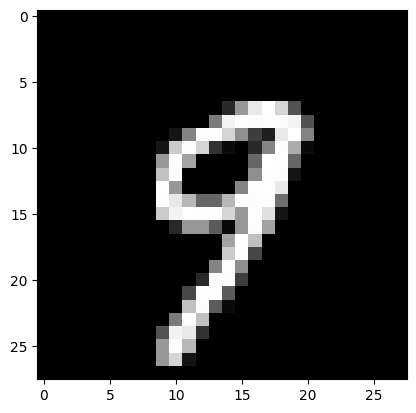

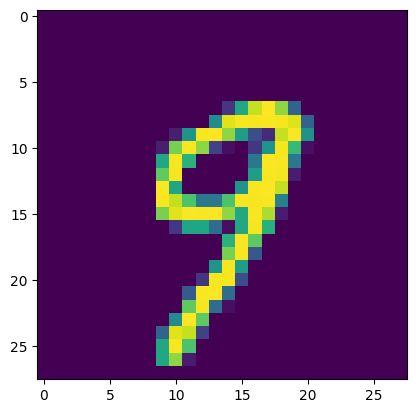

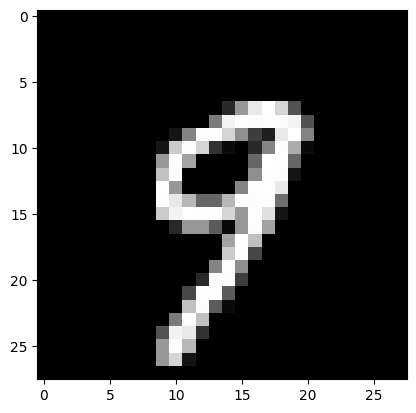

In [41]:
img = train_agumented_df[train_agumented_df.label == 9].images_rgb.values[8]
plt.figure()
plt.imshow(img)
print(img.shape)

img = Image.fromarray((img).astype(np.uint8)).convert('L')
plt.figure()
img = np.asarray(img)
plt.imshow(img)
print(img.shape)

img = Image.fromarray((img).astype(np.uint8)).convert('RGB')
plt.figure()
img = np.asarray(img)
plt.imshow(img)
print(img.shape)



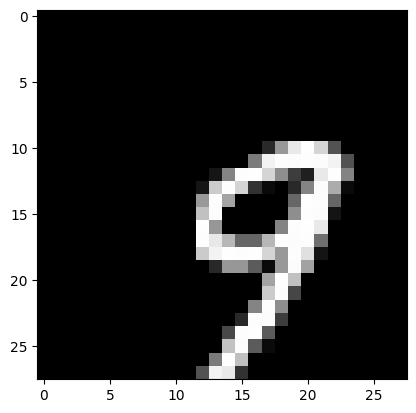

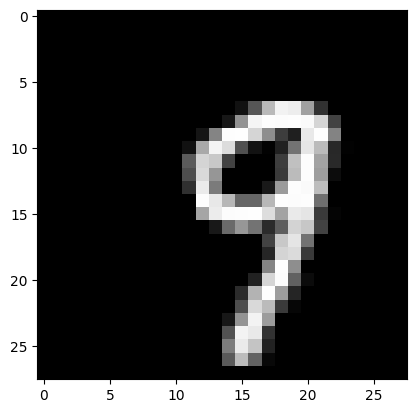

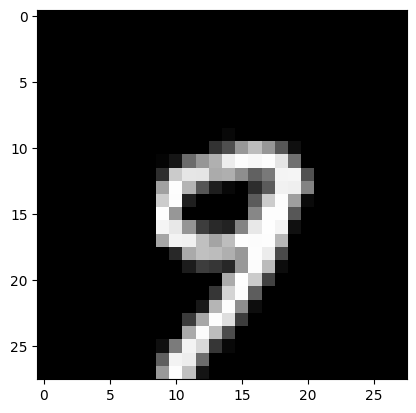

In [42]:

rows, cols, dim = img.shape
#**********IMAGE TRANSLATION*****************
# transformation matrix for translation
M = np.float32([[1, 0, 3],
                [0, 1, 3],
                [0, 0, 1]])
# apply a perspective transformation to the image
translated_img = cv2.warpPerspective(img, M, (cols, rows))
plt.imshow(translated_img)


plt.figure()
# transformation matrix for translation
M = np.float32([[1, 0.2, 0.2],
                [0, 1, 0],
                [0, 0, 1]])
# apply a perspective transformation to the image
translated_img = cv2.warpPerspective(img, M, (cols, rows))
plt.imshow(translated_img)

plt.figure()
# transformation matrix for translation
M = np.float32([[1, 0, 0],
                [0.2, 1, 0],
                [0, 0, 1]])
# apply a perspective transformation to the image
translated_img = cv2.warpPerspective(img, M, (cols, rows))
plt.imshow(translated_img)


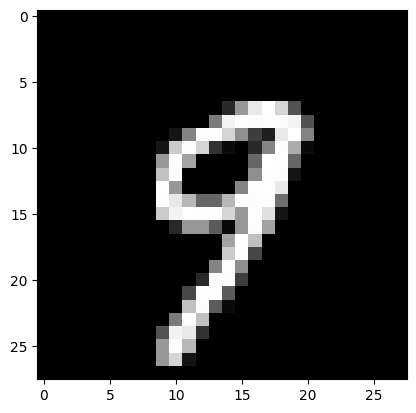

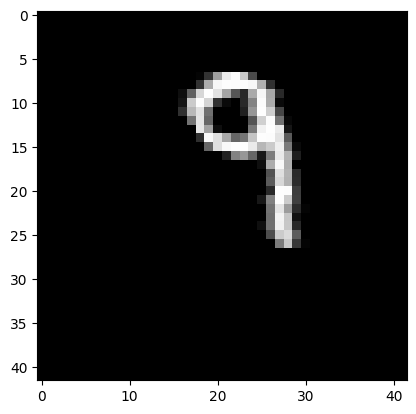

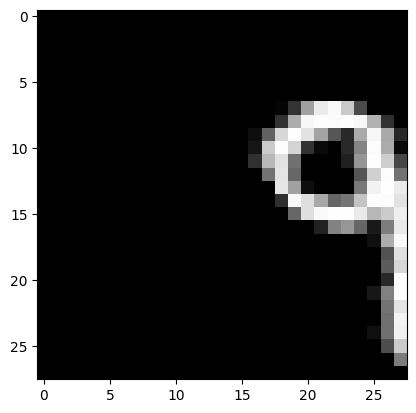

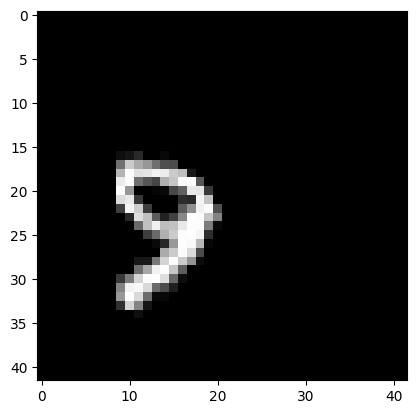

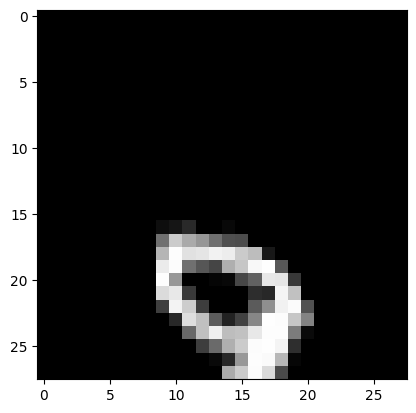

In [43]:
plt.figure()
plt.imshow(img)


#**********IMAGE SHEARING X AXIS*****************
plt.figure()
M = np.float32([[1, 0.7, 0],
             	[0, 1  , 0],
            	[0, 0  , 1]])
# apply a perspective transformation to the image                
sheared_img = cv2.warpPerspective(img,M,(int(cols*1.5),int(rows*1.5)))
plt.imshow(sheared_img)
plt.figure()
sheared_img = cv2.warpPerspective(img,M,(int(cols),int(rows)))
plt.imshow(sheared_img)


#**********IMAGE SHEARING Y AXIS*****************
plt.figure()
M = np.float32([[1,   0, 0],
             	[0.7, 1, 0],
             	[0,   0, 1]])
# apply a perspective transformation to the image                
sheared_img = cv2.warpPerspective(img,M,(int(cols*1.5),int(rows*1.5)))
plt.imshow(sheared_img)

plt.figure()
sheared_img = cv2.warpPerspective(img,M,(int(cols),int(rows)))
plt.imshow(sheared_img)  


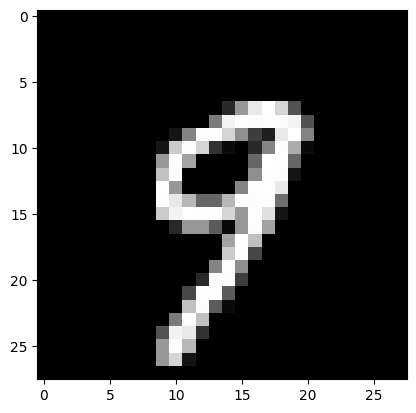

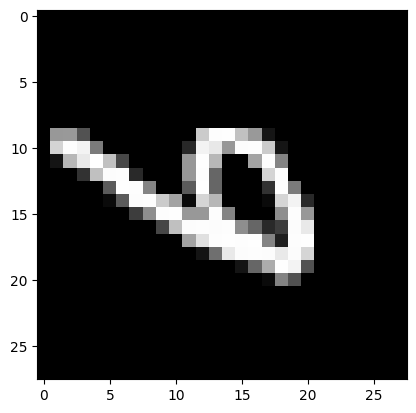

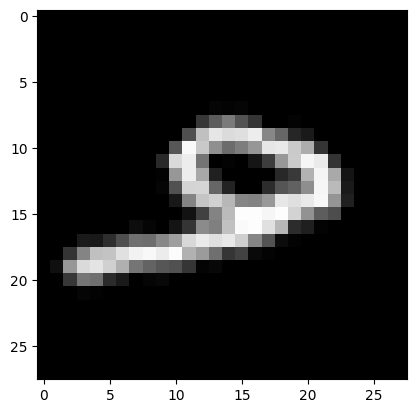

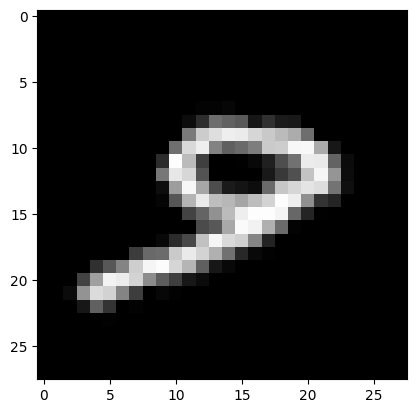

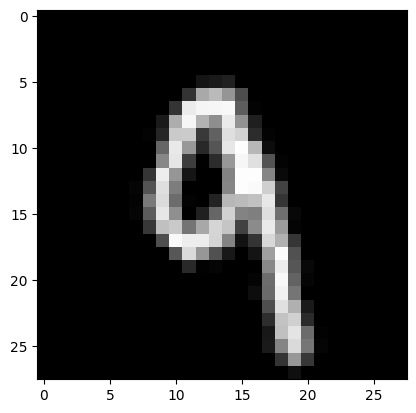

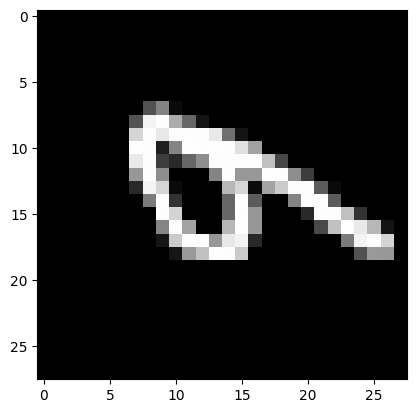

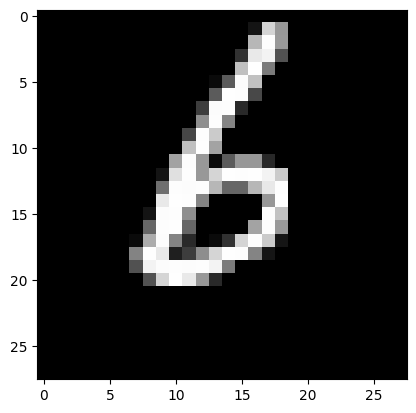

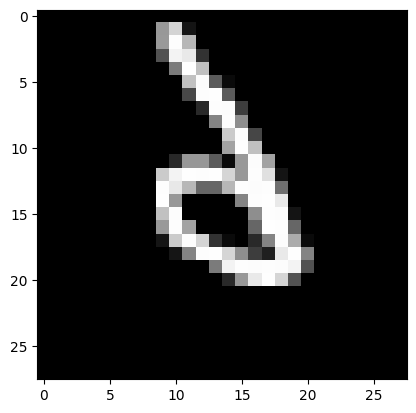

In [44]:

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result


img = Image.fromarray((img).astype(np.uint8)).convert('RGB')
plt.figure()
img = np.asarray(img)
plt.imshow(img)


#**********IMAGE ROTATION*****************
plt.figure()
img_rotate_90_clockwise = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(img_rotate_90_clockwise)

plt.figure()
plt.imshow(rotate_image(img, -45))


plt.figure()
plt.imshow(rotate_image(img, -35))

plt.figure()
plt.imshow(rotate_image(img, 45))

plt.figure()
img_rotate_90_counterclockwise  = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img_rotate_90_counterclockwise )

plt.figure()
img_rotate_180  = cv2.rotate(img, cv2.ROTATE_180)
plt.imshow(img_rotate_180 )

plt.figure()
img_flip_ud = cv2.flip(img, 0)
plt.imshow(img_flip_ud )



(28, 28)


(<matplotlib.image.AxesImage at 0x7a29283bdc50>, (28, 28, 3))

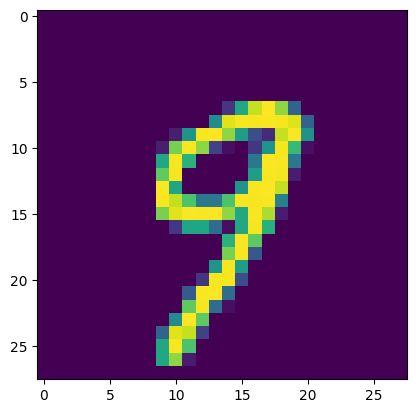

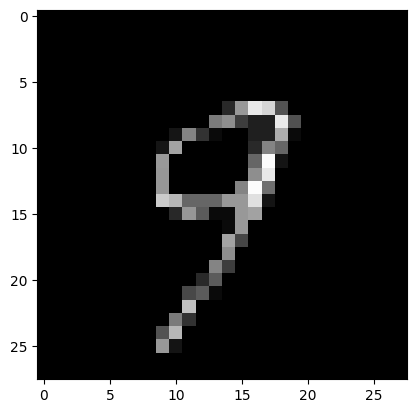

In [45]:
gray_image = np.asarray(Image.fromarray((img).astype(np.uint8)).convert('L'))
plt.imshow(gray_image)
print(gray_image.shape)

kernel = np.ones((2, 2), dtype=np.uint8)  # Define the kernel size for erosion
eroded_image = morphology.erosion(gray_image, kernel)
eroded_image =  np.asarray(Image.fromarray((eroded_image).astype(np.uint8)).convert('RGB'))

plt.figure()
plt.imshow(eroded_image), eroded_image.shape



In [46]:
train_agumented_df

images_rgb  label  \
0      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
1      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
2      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
3      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
4      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      9   
...                                                  ...    ...   
59995  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   
59996  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
59997  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
59998  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      6   
59999  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      8   

       prediction_prob  
0             1.000000  
1             1.000000  
2             1.000000  
3             1.000000  
4             0.999999  
...                ...  
59995         1.000000  
59996         1.000000  
59997         1.000000  
59998         1.000000  
59999         1.000000  

[60000 rows x 3 columns]

In [47]:
def data_aug( img, label):
    X_temp = []
    Y_temp = []
    

    #**********IMAGE TRANSLATION*****************
    rows, cols, dim = img.shape
    # transformation matrix for translation
    # M = np.float32([[1, 0, 3],
    #                 [0, 1, 3],
    #                 [0, 0, 1]])
    # # apply a perspective transformation to the image
    # X_temp.append(cv2.warpPerspective(img, M, (cols, rows)))
    # Y_temp.append(label)

    
    #**********IMAGE SHEARING X AXIS*****************
    M = np.float32([[1,   0, 0],
             	[0.7, 1, 0],
             	[0,   0, 1]])
    # apply a perspective transformation to the image  
    image_tmp = cv2.warpPerspective(img,M,(int(cols),int(rows)))
    X_temp.append(image_tmp)
    Y_temp.append(label)


    X_temp.append(rotate_image(img, -30))
    Y_temp.append(label)

    # Image Erosion
    gray_image = np.asarray(Image.fromarray((img).astype(np.uint8)).convert('L'))
    kernel = np.ones((2, 2), dtype=np.uint8)  # Define the kernel size for erosion
    eroded_image = morphology.erosion(gray_image, kernel)
    eroded_image =  np.asarray(Image.fromarray((eroded_image).astype(np.uint8)).convert('RGB'))

    X_temp.append(eroded_image)
    Y_temp.append(label)

    return X_temp,Y_temp


tmp = train_agumented_df

for img, label, prob in zip(tmp.images_rgb.values, tmp.label.values, tmp.prediction_prob.values):

    #if prob < 0.99:
    X_list, Y_list  = data_aug( img, label)
    tmp_df = pd.DataFrame({'images_rgb': [img for img in X_list]})
    tmp_df["label"] = Y_list
    train_agumented_df = pd.concat([train_agumented_df, tmp_df], axis = 0 )

In [48]:
train_agumented_df.shape

(240000, 3)

In [49]:
train_agumented_df.isna().sum()

images_rgb              0
label                   0
prediction_prob    180000
dtype: int64

<Axes: >

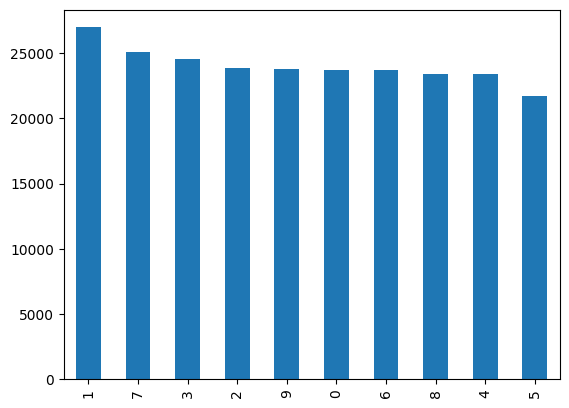

In [50]:
train_agumented_df.label.value_counts().plot(kind="bar")

# Retraining with new data 

In [51]:
stage = "train"
# for best_hps in tuner.get_best_hyperparameters(num_trials=1):
#     print(f"Best Hyperparameters: {best_hps.__dict__}")
#     model_v2 = tuner.hypermodel.build(best_hps)  # Build the model with best hyperparameters


In [52]:
%load_ext tensorboard


In [53]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/{stage}/")

train_input = np.array([img for img in train_agumented_df.images_rgb.values]).reshape(len(train_agumented_df), W, H, 3)
test_input = np.array([img for img in test_df.images_rgb.values]).reshape(len(test_df), W, H, 3)

y_train = train_agumented_df.label.values
y_test = test_df.label.values

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/tunning_{stage}/")


tuner = kt.BayesianOptimization(
            create_model,
            objective= kt.Objective('val_f1_m', direction="max"), 
            max_trials = 30,
            # distribution_strategy= strategy,
            directory="hyperparameter_tuning_v2",
            project_name="digit_hyperparam",
            #seed=0
        )


tuner.search(train_input, 
          y_train , 
          validation_data=(test_input, y_test),
          epochs= 150, 
          batch_size = 1024,
          callbacks=[tensorboard_callback]
        )


Reloading Tuner from hyperparameter_tuning_v2/digit_hyperparam/tuner0.json


In [54]:
for best_hps in tuner.get_best_hyperparameters(num_trials=1):
    print(f"Best Hyperparameters: {best_hps.__dict__}")
    model_v2 = tuner.hypermodel.build(best_hps)  # Build the model with best hyperparameters

model_v2.fit(train_input, 
          y_train , 
          validation_data=(test_input, y_test),
          epochs= 150, 
          batch_size = 1024,
          callbacks=[tensorboard_callback]
          )
                                 
model_v2.save('./checkpoints/model_v2.keras')
model_v2 = tf.keras.models.load_model('./checkpoints/model_v2.keras')

test_target_prob = model_v2.predict(test_input)

m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(y_test, test_target_prob)

sk.metrics.f1_score(y_test.reshape(-1,1), test_target_prob.argmax(axis = -1).reshape(-1,1), average = "weighted"), m.result()

Best Hyperparameters: {'_name_scopes': [], '_conditions': [], '_hps': defaultdict(<class 'list'>, {'n_conv_layers': [Int(name: 'n_conv_layers', min_value: 2, max_value: 4, step: 1, sampling: linear, default: 2)], 'use_batch_norm': [Choice(name: 'use_batch_norm', values: [1, 0], ordered: True, default: 1)], 'use_dropout': [Choice(name: 'use_dropout', values: [1, 0], ordered: True, default: 1)], 'learning_rate': [Float(name: 'learning_rate', min_value: '1e-06', max_value: '0.001', step: 'None', sampling: 'linear', default: '1e-06')], 'conv_0_unit': [Int(name: 'conv_0_unit', min_value: 32, max_value: 256, step: 32, sampling: linear, default: 32)], 'conv_0_filter': [Int(name: 'conv_0_filter', min_value: 2, max_value: 5, step: 1, sampling: linear, default: 2)], 'dropout_rate_0': [Float(name: 'dropout_rate_0', min_value: '0.1', max_value: '0.5', step: 'None', sampling: 'linear', default: '0.1')], 'conv_1_unit': [Int(name: 'conv_1_unit', min_value: 32, max_value: 256, step: 32, sampling: line

/home/n/anaconda3/envs/AI_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150


I0000 00:00:1720501306.474190    8155 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2527', 160 bytes spill stores, 156 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 69s 185ms/step - f1_m: 0.9884 - loss: 0.5252 - precision_m: 0.9895 - recall_m: 0.9876 - sparse_categorical_accuracy: 0.8668 - val_f1_m: 0.9984 - val_loss: 0.0930 - val_precision_m: 0.9982 - val_recall_m: 0.9986 - val_sparse_categorical_accuracy: 0.9791
Epoch 2/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 122ms/step - f1_m: 0.9982 - loss: 0.1168 - precision_m: 0.9981 - recall_m: 0.9982 - sparse_categorical_accuracy: 0.9715 - val_f1_m: 0.9986 - val_loss: 0.1495 - val_precision_m: 0.9992 - val_recall_m: 0.9980 - val_sparse_categorical_accuracy: 0.9747
Epoch 3/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - f1_m: 0.9986 - loss: 0.0948 - precision_m: 0.9986 - recall_m: 0.9986 - sparse_categorical_accuracy: 0.9783 - val_f1_m: 0.9989 - val_loss: 0.0912 - val_precision_m: 0.9985 - val_recall_m: 0.9992 - val_sparse_categorical_accuracy: 0.9840
Epoch 4/150
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - f1_m: 0.9988 - loss: 0.0801 - precision_m: 0.9988 - recall_m: 0.9988 - s

(0.9926980043469279, <tf.Tensor: shape=(), dtype=float32, numpy=0.9927>)

In [55]:
error_analysis_df = pd.DataFrame(y_test, columns = ["target"])
error_analysis_df["images"] = test_df[["images_rgb"]]
error_analysis_df

target                                             images
0          7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
1          2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
2          1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
3          0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
4          4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
...      ...                                                ...
9995       2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
9996       3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
9997       4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
9998       5  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
9999       6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

[10000 rows x 2 columns]

In [56]:
test_target_prob = model_v2.predict(test_input)
error_analysis_df["label"] = test_target_prob.argmax(axis=-1)
error_analysis_df["label_prob"] = test_target_prob.max(axis  =-1)
error_analysis_df

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


target                                             images  label  \
0          7  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      7   
1          2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
2          1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1   
3          0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      0   
4          4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
...      ...                                                ...    ...   
9995       2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      2   
9996       3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      3   
9997       4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      4   
9998       5  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      5   
9999       6  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      6   

      label_prob  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0  
...          ...  
9995         1.0  
9996         1.0  
9997         1.0  
9998         1.0  
9999         1.0  

[10000 rows x 4 columns]

In [57]:
multilabel_confusion_matrix(error_analysis_df.target, error_analysis_df.label)

array([[[9012,    8],
        [   3,  977]],

       [[8857,    8],
        [   3, 1132]],

       [[8953,   15],
        [   6, 1026]],

       [[8984,    6],
        [   5, 1005]],

       [[9009,    9],
        [   4,  978]],

       [[9103,    5],
        [   9,  883]],

       [[9037,    5],
        [   6,  952]],

       [[8967,    5],
        [  16, 1012]],

       [[9022,    4],
        [  10,  964]],

       [[8983,    8],
        [  11,  998]]])

In [58]:
error_analysis_df[
    (error_analysis_df.target != error_analysis_df.label)
    ].target.value_counts() 

7    16
9    11
8    10
5     9
2     6
6     6
3     5
4     4
1     3
0     3
Name: target, dtype: int64

# Improvements after error analysis and hyperparam tunning:
### F1 score : 0.9906 -> 0.9926 
### Accuracy: 0.9907 -> 0.9927  